# Signal Processing Examples

In [1]:
import numpy as np
import sys
sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.agent_types.op import map_window
from IoTPy.helper_functions.recent_values import recent_values

In [2]:
def window_dot_product(in_stream, out_stream, multiplicand_vector, step_size=1):
    def f(window, multiplicand_vector): return np.dot(window, multiplicand_vector)
    map_window(f, in_stream, out_stream,
               len(multiplicand_vector), step_size, multiplicand_vector=multiplicand_vector)

In [3]:
def bandpass_FIR(in_stream, out_stream, b):
    window_dot_product(in_stream, out_stream, multiplicand_vector=reverse_b)

In [4]:
def generate_trignometric_wave(
        func, frequency, max_amplitude,
        phase_shift, sample_rate, time_duration):
    num_samples = int(time_duration * sample_rate)
    time_sequence = np.linspace(0, time_duration, num_samples, endpoint=False)
    return max_amplitude*func(2*np.pi*(frequency*time_sequence) + phase_shift)

In [5]:
def generate_sine_wave(
        frequency, max_amplitude, phase_shift,
        sample_rate, time_duration):
    return generate_trignometric_wave(
        np.sin, frequency, max_amplitude, phase_shift,
        sample_rate, time_duration)

In [6]:
def generate_cosine_wave(
        frequency, max_amplitude, phase_shift,
        sample_rate, time_duration):
    return generate_trignometric_wave(
        np.cos, frequency, max_amplitude, phase_shift,
        sample_rate, time_duration)

In [7]:
def generate_square_wave(
        frequency, max_amplitude,
        phase_shift, sample_rate, time_duration):
    num_samples = time_duration * sample_rate
    time_sequence = np.linspace(0, time_duration, num_samples, endpoint=False)
    def func(v):
        return - np.sign((v - v.astype(int)) - 0.45)
    return max_amplitude*func(frequency*time_sequence + phase_shift)

In [8]:
from IoTPy.agent_types.op import map_element
class Filter(object):
    """
    The base class of filters that filter input streams to
    produc output streams.
    Uses a, b parameters from scipy.signal or other libraries.

    Parameters
    ----------
    a, b: list of float
      Parameters that define a filter.
      For a Finite Impulse Response filter, a is None.

    Attributes
    ----------
    N: int
      the length of b
    x: array of float
      The N most recent values of the input stream.
      x[0] is the most recent value. For example if
      the current value of in_stream is:
      in_stream[j-N+1, ... j] then
      x[k] = in_stream[j - k]
      x is initialized to 0.
    y: array of float
      The N most recent values of the output stream.
      Initialized to 0.
      y and x have the same structure.

    """
    def __init__(self, b, a=None):
        self.b = np.array(b)
        if a is not None:
            self.a = np.array(a)
        self.N = len(b)
        self.x = np.zeros(self.N)
        self.y = np.zeros(self.N)

    def filter_element(self, element):
        """
        This is the standard filter calculation.
        The formula depends on the type of filter.
        The formula must be entered for the subclass
        derived from the base Filter class.

        Parameters
        ----------
        element: float or int
          The next element of the stream.
        """
        pass

    def filter_stream(self, in_stream, out_stream):
        """
        Filters the input stream to get the output stream using
        the function filter_element.

        """
        map_element(self.filter_element, in_stream, out_stream)

In [9]:
class BP_FIR(Filter):
    """
    Bandpass FIR (Finite Impulse Response) Filter.

    Parameters
    ----------
       b: float or int
          Filter parameters obtained from scipy.signal.butter
          or other sources.

    """
    def __init__(self, b):
        Filter.__init__(self, b)

    def filter_element(self, element):
        """
        Uses a standard formula for FIR filters.
        Shifts x, y to the right by 1 to accomodate
        new entry for input x, and compute output.

        """
        # Accomodate new entry, element, in input
        # stream x.
        self.x[1:] = self.x[:- 1]
        self.x[0] = element
        return np.sum(self.b * self.x)

In [10]:
class BP_IIR(Filter):
    """
    Bandpass IIR (Infinite Impulse Response) Filter.

    Parameters
    ----------
       a, b: float or int
          Filter parameters obtained from scipy.signal.butter
          or other sources.

    """
    def __init__(self, b, a):
        Filter.__init__(self, b, a)

    def filter_element(self, element):
        """
        Uses a standard formula for IIR filters.
        Shifts x, y to the right by 1 to accomodate
        new entry for input x, and then updates y[0].

        """
        # Insert a new value -- element --- into x.
        # First shift x to the right by 1.
        self.x[1:] = self.x[:- 1]
        self.x[0] = element
        
        # Insert a new value into y.
        # First shift y to the right by 1.
        self.y[1:] = self.y[:-1]
        # Compute new value for y[0]
        self.y[0] = self.b[0] * self.x[0]
        self.y[0] += sum(self.b[1:]*self.x[1:] -
                         self.a[1:]*self.y[1:])
        return self.y[0]

In [11]:
# See scipy.signal for a library of filters.
from scipy.signal import butter, firwin
def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Butterworth IIR filter.
    butter() is from scipy.signal

    """
    lowcut, highcut = lowcut*2.0/fs, highcut*2.0/fs
    b, a = butter(order, [lowcut, highcut], btype='band')
    return b, a

In [12]:
def fir_bandpass(lowcut, highcut, fs):
    """
    FIR filter.
    firwin() is from scipy.signal

    """
    lowcut, highcut =lowcut*2.0/fs, highcut*2.0/fs
    b =  firwin(
        numtaps=201, cutoff = [lowcut, highcut],
        window='blackmanharris', pass_zero=False)
    return b 

In [13]:
# SET PARAMETERS
# fs: sample rate
# order: order of the filter
# lowcut, highcut: lower and upper thresholds of a bandpass
# filter.
fs, order, lowcut, highcut = 50.0, 4, 1.0, 4.0

In [14]:
low_frequency=0.1,
medium_frequency = 2.0
high_frequency = 10.0
max_amplitude=1.0, 
phase_shift=0.0, 
sample_rate=fs,
time_duration=5.0

wave_data_low_frequency = generate_sine_wave(
    low_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_medium_frequency = generate_sine_wave(
    medium_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_high_frequency = generate_sine_wave(
    high_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_total = (wave_data_low_frequency +
                   wave_data_medium_frequency +
                   wave_data_high_frequency)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

x = StreamArray('x')
y = StreamArray('y')
# Create bandpass filter 
b, a = butter_bandpass(lowcut, highcut, fs, order)
BP_IIR(b, a).filter_stream(in_stream=x, out_stream=y)
x.extend(wave_data_total)
run()

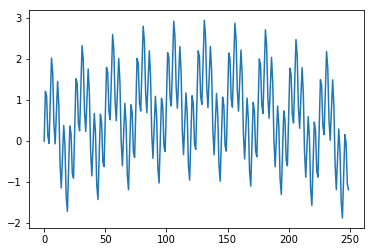

In [16]:
plt.plot(recent_values(x))
plt.show()

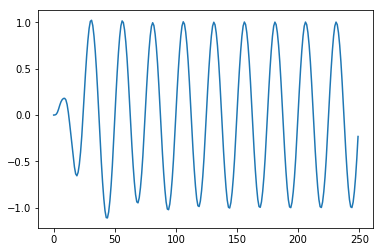

In [17]:
plt.plot(recent_values(y))
plt.show()